# VGGish + Tabular Features Training
## FastAI Tabular Model on Single-Label Audio Classification

This notebook combines:
- **128 VGGish embeddings** (pre-trained audio features)
- **2,474 tabular features** (STFT, Mel spectrograms)
- **Total: 2,602 features**

Training on **single-label samples only** (74 classes)

In [20]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# FastAI
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
torch.set_num_threads(4)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Merge Data

In [21]:
# Load VGGish embeddings
vggish_df = pd.read_csv('work/tokenized/vggish_embeddings_train_curated.csv')
print(f"VGGish embeddings: {vggish_df.shape}")
print(f"Columns: {list(vggish_df.columns[:5])}...")

# Load tabular features  
tabular_df = pd.read_csv('work/trn_curated_feature.csv')
print(f"\nTabular features: {tabular_df.shape}")
print(f"Columns: {list(tabular_df.columns[:5])}...")

VGGish embeddings: (3524, 130)
Columns: ['fname', 'labels', 'emb_0', 'emb_1', 'emb_2']...

Tabular features: (4970, 2475)
Columns: ['file', 'stft_mean_0', 'stft_mean_1', 'stft_mean_2', 'stft_mean_3']...


In [22]:
# Merge datasets
tabular_df = tabular_df.rename(columns={'file': 'fname'})
merged_df = vggish_df.merge(tabular_df, on='fname', how='inner')

print(f"Merged data: {merged_df.shape}")

# Check for and remove rows with NaN values
feature_cols_check = [col for col in merged_df.columns if col not in ['fname', 'labels']]
nan_mask = merged_df[feature_cols_check].isna().any(axis=1)
n_nan_rows = nan_mask.sum()

if n_nan_rows > 0:
    print(f"\nWARNING: Found {n_nan_rows} row(s) with NaN values")
    nan_files = merged_df[nan_mask]['fname'].tolist()
    print(f"Files with NaN: {nan_files}")
    print("Dropping these rows to prevent training issues...")
    merged_df = merged_df[~nan_mask].copy()
    print(f"After dropping NaN rows: {merged_df.shape}")
else:
    print(f"No NaN values found - data is clean!")

print(f"\nSample:\n{merged_df.head(2)}")

Merged data: (3524, 2604)

Files with NaN: ['1d44b0bd.wav']
Dropping these rows to prevent training issues...
After dropping NaN rows: (3523, 2604)

Sample:
          fname    labels      emb_0      emb_1      emb_2     emb_3  \
0  0006ae4e.wav      Bark  158.28572  21.285715  176.28572  88.28571   
1  0019ef41.wav  Raindrop  156.50000   1.000000  168.00000  95.50000   

       emb_4      emb_5     emb_6      emb_7  ...  cqt_std_74  cqt_std_75  \
0  227.14285  55.142857  92.85714  110.14286  ...    0.141729    0.123818   
1  183.00000  86.500000  81.50000   95.50000  ...    0.142544    0.140708   

   cqt_std_76  cqt_std_77  cqt_std_78  cqt_std_79  cqt_std_80  cqt_std_81  \
0    0.097963    0.098019    0.108474    0.114210    0.101129    0.088244   
1    0.126795    0.122447    0.133664    0.148726    0.155113    0.169245   

   cqt_std_82  cqt_std_83  
0    0.098404    0.104893  
1    0.179506    0.178364  

[2 rows x 2604 columns]


## 2. Filter to Single-Label Samples

In [23]:
# Count labels per sample
merged_df['num_labels'] = merged_df['labels'].apply(
    lambda x: len(x.split(',')) if isinstance(x, str) else 0
)

print("Label distribution:")
print(merged_df['num_labels'].value_counts().sort_index())

# Filter to single-label only
df = merged_df[merged_df['num_labels'] == 1].copy()

print(f"\n{'='*60}")
print(f"FILTERED TO SINGLE-LABEL SAMPLES")
print(f"{'='*60}")
print(f"Original: {len(merged_df)} samples")
print(f"Single-label: {len(df)} samples ({len(df)/len(merged_df)*100:.1f}%)")
print(f"Removed: {len(merged_df) - len(df)} multi-label samples")

# Unique classes
unique_labels = sorted(df['labels'].unique())
print(f"\nUnique classes: {len(unique_labels)}")
print(f"Sample classes: {unique_labels[:5]}...")

Label distribution:
num_labels
1    2977
2     475
3      66
4       4
6       1
Name: count, dtype: int64

FILTERED TO SINGLE-LABEL SAMPLES
Original: 3523 samples
Single-label: 2977 samples (84.5%)
Removed: 546 multi-label samples

Unique classes: 74
Sample classes: ['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Bark', 'Bass_drum']...


## 3. Prepare Features and Split Data

In [24]:
# Define feature columns
vggish_cols = [f'emb_{i}' for i in range(128)]
tabular_cols = [col for col in tabular_df.columns if col != 'fname']
feature_cols = vggish_cols + tabular_cols

print(f"Feature breakdown:")
print(f"  VGGish embeddings: {len(vggish_cols)}")
print(f"  Tabular features: {len(tabular_cols)}")
print(f"  Total features: {len(feature_cols)}")

# Reset index
df = df.reset_index(drop=True)

# Train/validation split (stratified)
train_idx, val_idx = train_test_split(
    range(len(df)),
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

df['is_valid'] = False
df.loc[val_idx, 'is_valid'] = True

print(f"\nTrain samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Feature breakdown:
  VGGish embeddings: 128
  Tabular features: 2474
  Total features: 2602

Train samples: 2381
Validation samples: 596


## 4. Create FastAI DataLoaders

In [25]:
# Create TabularDataLoaders
dls = TabularDataLoaders.from_df(
    df,
    path='.',
    procs=[Categorify, Normalize],
    cat_names=[],  # No categorical features
    cont_names=feature_cols,  # All features continuous
    y_names='labels',
    valid_idx=df[df['is_valid']].index.tolist(),
    bs=64
)

print("DataLoaders created!")
print(f"Train batches: {len(dls.train)}")
print(f"Valid batches: {len(dls.valid)}")

# Show a sample batch
dls.show_batch()

DataLoaders created!
Train batches: 37
Valid batches: 10


## 5. Create Model with 2 Layers [200, 100]

In [26]:
# Create learner
learn = tabular_learner(
    dls,
    layers=[200, 100],
    metrics=[accuracy, error_rate],
    loss_func=CrossEntropyLossFlat()
)

print("Model created!")
print(f"\nArchitecture:")
print(learn.model)

num_params = sum(p.numel() for p in learn.model.parameters())
print(f"\nTotal parameters: {num_params:,}")

Model created!

Architecture:
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2602, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=2602, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=74, bias=True)
    )
  )
)

Total parameters: 553,678


## 6. Find Optimal Learning Rate

**CRITICAL STEP**: With 2,602 features, we need to find the right learning rate!

Running LR finder...




Suggested LR (valley): 8.32e-04



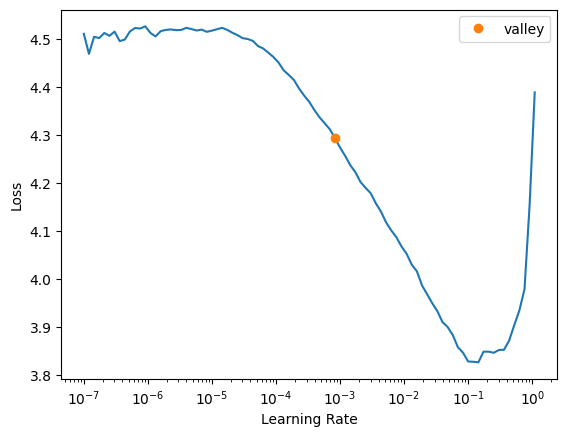

In [27]:
# LR Finder
print("Running LR finder...\n")
lr_result = learn.lr_find()

print(f"\nSuggested LR (valley): {lr_result.valley:.2e}")
print(f"Suggested LR (steep): {lr_result.steep:.2e}" if hasattr(lr_result, 'steep') else "")

In [28]:
# Choose learning rate based on LR finder
# Use the valley value (or manually set if needed)
optimal_lr = float(lr_result.valley) if hasattr(lr_result, 'valley') else 1e-3

print(f"Selected learning rate: {optimal_lr:.2e}")
print(f"\nIf this seems too low (< 1e-4), consider increasing it manually.")
print(f"For high-dimensional data, typical good values are: 1e-3 to 1e-2")

Selected learning rate: 8.32e-04

If this seems too low (< 1e-4), consider increasing it manually.
For high-dimensional data, typical good values are: 1e-3 to 1e-2


## 7. Train Model for 20 Epochs

In [29]:
# Override LR if needed (uncomment if LR finder gave bad result)
optimal_lr = 1e-3  # or try 5e-3

print(f"Training with LR: {optimal_lr:.2e}")
print(f"Epochs: 20\n")

start_time = datetime.now()

# Train!
learn.fit_one_cycle(20, lr_max=optimal_lr)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"{'='*60}")

Training with LR: 1.00e-03
Epochs: 20



epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.091337,3.799509,0.167785,0.832215,00:00
1,3.684050,3.298189,0.293624,0.706376,00:00
2,3.303067,2.864398,0.387584,0.612416,00:00
3,2.926337,2.514737,0.434564,0.565436,00:00
4,2.546084,2.245838,0.489933,0.510067,00:00
5,2.217932,2.031289,0.520134,0.479866,00:00
6,1.902711,1.850017,0.541946,0.458054,00:00
7,1.650538,1.717847,0.558725,0.441275,00:00
8,1.467104,1.629553,0.577181,0.422819,00:00
9,1.299207,1.546323,0.597315,0.402685,00:00



Training completed!
Time: 11.57s (0.19 min)


In [36]:
learn.fit_one_cycle(20, lr_max=optimal_lr/10000)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.210116,1.221846,0.687919,0.312081,00:00
1,0.206713,1.215704,0.682886,0.317114,00:00
2,0.210475,1.216846,0.684564,0.315436,00:00
3,0.209897,1.215286,0.686242,0.313758,00:00
4,0.210924,1.217043,0.687919,0.312081,00:00
5,0.208080,1.214159,0.684564,0.315436,00:00
6,0.208052,1.214669,0.686242,0.313758,00:00
7,0.209061,1.220650,0.681208,0.318792,00:00
8,0.211512,1.221535,0.684564,0.315436,00:00
9,0.212809,1.220369,0.692953,0.307047,00:00


## 8. Evaluate Model

In [30]:
# Get predictions
val_preds, val_targets = learn.get_preds(dl=dls.valid)
val_preds_class = val_preds.argmax(dim=1)

# Calculate accuracy
val_accuracy = accuracy_score(
    val_targets.cpu().numpy(), 
    val_preds_class.cpu().numpy()
)

print(f"{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Error Rate: {1-val_accuracy:.4f} ({(1-val_accuracy)*100:.2f}%)")
print(f"\nRandom Baseline: {1/74:.4f} ({100/74:.2f}%)")
print(f"Improvement over random: {val_accuracy/(1/74):.1f}x")

FINAL RESULTS
Validation Accuracy: 0.6846 (68.46%)
Error Rate: 0.3154 (31.54%)

Random Baseline: 0.0135 (1.35%)
Improvement over random: 50.7x


## 9. Training History

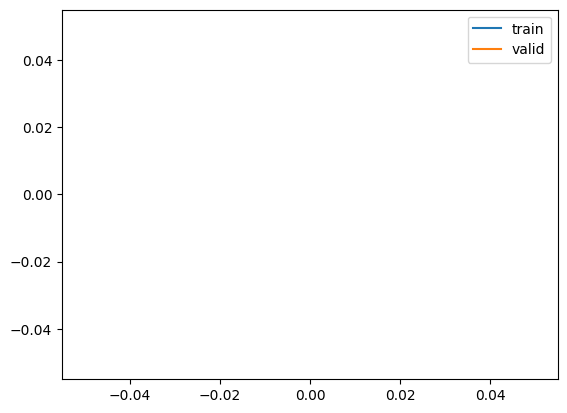

In [31]:
# Plot training history
learn.recorder.plot_loss()

## 10. Save Model and Results

In [32]:
# Create models directory
Path('models').mkdir(exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_name = f'vggish_tabular_2layers_{timestamp}'
learn.export(f'models/{model_name}.pkl')

print(f"Model saved: models/{model_name}.pkl")

# Save results to CSV
results = {
    'timestamp': timestamp,
    'model': '2 layers [200, 100]',
    'features': len(feature_cols),
    'vggish_features': len(vggish_cols),
    'tabular_features': len(tabular_cols),
    'num_classes': len(unique_labels),
    'train_samples': len(train_idx),
    'val_samples': len(val_idx),
    'epochs': 20,
    'learning_rate': optimal_lr,
    'training_time_sec': training_time,
    'val_accuracy': val_accuracy,
    'error_rate': 1 - val_accuracy,
    'num_params': num_params
}

results_df = pd.DataFrame([results])
results_file = f'vggish_tabular_results_{timestamp}.csv'
results_df.to_csv(results_file, index=False)

print(f"Results saved: {results_file}")
print(f"\nResults summary:")
print(results_df.T)

Model saved: models/vggish_tabular_2layers_20251016_182328.pkl
Results saved: vggish_tabular_results_20251016_182328.csv

Results summary:
                                     0
timestamp              20251016_182328
model              2 layers [200, 100]
features                          2602
vggish_features                    128
tabular_features                  2474
num_classes                         74
train_samples                     2381
val_samples                        596
epochs                              20
learning_rate                    0.001
training_time_sec            11.569927
val_accuracy                  0.684564
error_rate                    0.315436
num_params                      553678


## 11. Top Predictions Analysis (Optional)

In [33]:
# Get class names
vocab = list(dls.vocab[1])

# Show confusion on a few samples
val_targets_np = val_targets.cpu().numpy()
val_preds_np = val_preds_class.cpu().numpy()

# Find correct and incorrect predictions
correct_mask = val_targets_np == val_preds_np
incorrect_mask = ~correct_mask

print(f"Correct predictions: {correct_mask.sum()}/{len(correct_mask)}")
print(f"Incorrect predictions: {incorrect_mask.sum()}/{len(incorrect_mask)}")

# Show some misclassifications
if incorrect_mask.sum() > 0:
    print(f"\nSample misclassifications:")
    incorrect_indices = np.where(incorrect_mask)[0][:5]
    for idx in incorrect_indices:
        true_class = vocab[val_targets_np[idx]]
        pred_class = vocab[val_preds_np[idx]]
        confidence = val_preds[idx][val_preds_np[idx]].item()
        print(f"  True: {true_class:30s} | Predicted: {pred_class:30s} | Conf: {confidence:.3f}")

Correct predictions: 5984/596
Incorrect predictions: 349232/596

Sample misclassifications:


TypeError: only integer scalar arrays can be converted to a scalar index

## Summary

This notebook trained a FastAI tabular model combining:
- **VGGish embeddings** (128 features)
- **Tabular features** (2,474 features)
- **Total input**: 2,602 features

Model architecture: **2 layers [200, 100]**  
Training: **20 epochs** with **optimal LR from LR finder**

The model is saved and ready for inference!